In [ ]:
sc

# ================================
# READ TO CSV FROM HDFS VIA SPARK
# ================================

In [ ]:
%%time
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession.builder.appName("HDFSToCSV").getOrCreate()

# Read CSV file with Spark DataFrame
df = spark.read.csv("/ProjectTweets.csv", header=False, inferSchema=True)

In [ ]:
# Show DataFrame First 5 Rows
df.show(5)

In [ ]:
df.printSchema()

In [ ]:
# The first method for renamed the column names
# df = df.withColumnRenamed("_c0", "id").withColumnRenamed("_c1", "stamp").withColumnRenamed("_c2", "date").withColumnRenamed("_c3", "flag").withColumnRenamed("_c4", "user").withColumnRenamed("_c5", "text")

# The second method for renamed the column names
df = df.selectExpr("_c0 as ID", "_c1 as STAMP", "_c2 as DATE", "_c3 as FLAG", "_c4 as USER", "_c5 as TEXT")
df.show(5)

In [ ]:
# How many rows does the dataframe 
row_count = df.count()
# Print row_count
print("DataFrame has {} rows.".format(row_count))

In [ ]:
from pyspark.sql.functions import col

columns = ["ID", "STAMP", "DATE", "FLAG", "USER", "TEXT"]

Columns = df.columns

# Check out the each column and Count unique values
for column in Columns:
    unique_values = df.select(column).distinct()
    unique_count = unique_values.count()
    
    if unique_count > 0:
        print(f"{column} has {unique_count} unique values:")
    else:
        print(f"{column} has no unique value.")

In [ ]:
from pyspark.sql.functions import col

columns = ["ID", "STAMP", "DATE", "FLAG", "USER", "TEXT"]

Columns = df.columns

# Check out the each column and Count duplicate values
for column in Columns:
    count_df = df.groupBy(column).count()
    duplicate_values = count_df.filter(col("count") > 1).count()
    
    if duplicate_values > 0:
        print(f"{column} has {duplicate_values} duplicate values.")
    else:
        print(f"{column} has no duplicate value.")

In [ ]:
# Drop the selected columns
df = df.drop("ID", "STAMP", "FLAG", "USER")
df.show(5)

In [ ]:
df.describe().show()

In [ ]:
df.summary().show()

In [ ]:
from pyspark.sql.functions import col

# Do a grouping and counting operation to find duplicate values in the "TEXT" column
count_df = df.groupBy("TEXT").count()

# Filter rows containing duplicate values
duplicate_values = count_df.filter(col("count") > 1)

# If there are duplicate values, show them
if duplicate_values.count() > 0:
    print("Duplicate values:")
    duplicate_values.show(truncate=False)  # Display column values in full length
else:
    print("No duplicate values found.")

In [ ]:
# How many rows does the dataframe 
row_count = df.count()
# Print row_count
print("DataFrame has {} rows.".format(row_count))

In [ ]:
df.printSchema()

# =====================
# TEXT PRE-PROCESSING
# =====================

In [ ]:
from pyspark.sql.functions import col, udf, lower, regexp_replace
from pyspark.sql.types import ArrayType, StringType, FloatType

import string
import nltk
import re
import contractions
import torch

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer 

from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import word_tokenize

In [ ]:
df.select("TEXT").show(3, truncate=False)

#### TEXT CLEANING

In [ ]:
import re

# Cleaning Function
def clean_text(text):
    text = text.strip()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s\s+', ' ', text)
    text = re.sub(r'[@_!#$%^&*()<>?/\|}{~:]', '', text)
    text = text.lower()
    return text

# Save as UDF
clean_text_udf = udf(clean_text, StringType())

# Create new column
df = df.withColumn("TEXT_C1", clean_text_udf(col("text")))
df.select("TEXT", "TEXT_C1").show(3, truncate=False)

#### EXPAND CONTRACTIONS

In [ ]:
import contractions

# Function to expand contractions
def expand_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text

# Save as UDF
expand_contractions_udf = udf(expand_contractions, StringType())

# Use the UDF and Create new column
df = df.withColumn("TEXT_C2", expand_contractions_udf(col("TEXT_C1")))

# Show the dataframe
df.select("TEXT", "TEXT_C1", "TEXT_C2").show(3, truncate=False)

#### CLEAN THE PUNCTUATION CHARACTERS

In [ ]:
# Define punctuation characters
punctuation_characters = r'[!\"#\$%&\'\(\)\*\+,\-./:;<=>\?@[\\]\^_`{|}~]'

# Remove punctuation characters
df = df.withColumn("TEXT_C3", regexp_replace(col("TEXT_C2"), punctuation_characters, ""))

# Show the dataframe
df.select("TEXT", "TEXT_C1", "TEXT_C2", "TEXT_C3").show(3, truncate=False)

#### CLEAN THE STOPWORDS

In [ ]:
# Download "stopwords" from nltk dictionary
nltk.download("stopwords")

# Configure the language as english
stop_words = set(stopwords.words("english"))

# Define the udf 
remove_stopwords_udf = udf(lambda text: " ".join([word for word in text.split() if word not in stop_words]), StringType())

# Use the UDF in order to remove stopwords and Create new column
df = df.withColumn("TEXT_C4", remove_stopwords_udf(col("TEXT_C3")))

# Show the dataframe
df.select("TEXT", "TEXT_C1", "TEXT_C2", "TEXT_C3", "TEXT_C4").show(3, truncate=False)

#### IMPLEMENT LEMMATIZATION

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download 'punkt','averaged_perceptron_tagger','wordnet' from nltk dictionary
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Defining the function that implements the Lemmatization operation as a UDF
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    words = word_tokenize(text)
    for w in words:
        lemma = lemmatizer.lemmatize(w)
        lemmatized_sentence.append(lemma)
    lemmatized_text = " ".join(lemmatized_sentence)
    return lemmatized_text

# Define the UDF
lemmatize_text_udf = udf(lemmatize_text, StringType())

# Use the UDF and Create new column
df = df.withColumn("TEXT_C5", lemmatize_text_udf(df["TEXT_C4"]))

# Show the dataframe
df.select("TEXT", "TEXT_C1", "TEXT_C2", "TEXT_C3", "TEXT_C4", "TEXT_C5").show(3, truncate=False)

#### IMPLEMENT STEMMING

In [ ]:
from nltk.stem import SnowballStemmer

# Defining the function that finds word roots as UDF 
def stem_text(text):
    snow = SnowballStemmer('english')
    stemmed_sentence = []
    words = word_tokenize(text)
    for w in words:
        stemmed_sentence.append(snow.stem(w))
    stemmed_text = " ".join(stemmed_sentence)
    return stemmed_text

# Define the UDF
stem_text_udf = udf(stem_text, StringType())

# Use the UDF and Create new column
df = df.withColumn("TEXT_C6", stem_text_udf(df["TEXT_C5"]))

# Show the dataframe
df.select("TEXT", "TEXT_C1", "TEXT_C2", "TEXT_C3", "TEXT_C4", "TEXT_C5", "TEXT_C6").show(3, truncate=False)

#### IMPLEMENT TOKENIZATION

In [ ]:
from pyspark.sql.types import ArrayType, StringType
from nltk.tokenize import word_tokenize

# Function that splits text into tokens using NLTK
def tokenize_text(text):
    words = word_tokenize(text)
    return words

# Define the UDF
tokenize_text_udf = udf(tokenize_text, ArrayType(StringType()))

# Use the UDF and Create new column
df = df.withColumn("TOKENS", tokenize_text_udf(df["TEXT_C6"]))

# Show the selected dataframe
df.select("TEXT", "TEXT_C6", "TOKENS").show(3, truncate=False)

#### DROP THE REDUNDANT COLUMNS

In [ ]:
df.show(5)

In [ ]:
# Drop the selected columns
df = df.drop("TEXT_C1", "TEXT_C2", "TEXT_C3", "TEXT_C4", "TEXT_C5")
df.show(5)

#### IMPLEMENT TOKENIZATION AND SPLIT WORDS TO ROWS

In [ ]:
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import explode, col

# Create The Tokenizer
tokenizer = Tokenizer(inputCol="TEXT_C6", outputCol="words")
tokenizer_df = tokenizer.transform(df)

# Separate words into individual lines
tokenizer_df = tokenizer_df.select(explode(col("words")).alias("word"))

# Show the dataframe
tokenizer_df.show(3, truncate=False)

#### Table 1: Count The Tokenizer Words

In [ ]:
%%time
# Count the tokenizer words
tokenizer_df_count = tokenizer_df.groupBy("word").count().orderBy("count", ascending=False)

# Show the dataframe
tokenizer_df_count.show(50)

#### Figure 1: WordCloud The Tokenizer Words

In [ ]:
%%time
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Convert the Spark DataFrame to Pandas DataFrame
pandas_df_count = tokenizer_df_count.toPandas()

# Create a dictionary from the Pandas DataFrame for word frequencies
word_freq_dict = dict(zip(pandas_df_count['word'], pandas_df_count['count']))

# Generate WordCloud for positive sentiments
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, width=1600, height=800).generate_from_frequencies(word_freq_dict)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## ==============
## Text Blob Method
## ==============
#### SENTIMENT SCORES AND SENTIMENT LABEL

In [ ]:
%%time

from textblob import TextBlob

# Sentimental Analysis Function
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Sentiment Label Function
def label_sentiment(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

#=========================================================================================#

from pyspark.sql.types import FloatType, StringType

# Define the UDF with Functions
sentiment_udf = udf(get_sentiment, FloatType())
label_udf = udf(label_sentiment, StringType())

# Use the UDF and Create new columns
df = df.withColumn('SentimentScores', sentiment_udf(df['TEXT_C6']))
df = df.withColumn('SentimentLabels', label_udf(df['SentimentScores']))

# Show the Selected Columns
df.select("TEXT_C6", "SentimentLabels", "SentimentScores").show(truncate=False)

#### TABLE 2: SENTIMENT LABEL COUNT ( POSITIVE - NEGATIVE - NEUTRAL )

In [ ]:
# Count and Show the 'sentiment_label' column
df.groupBy('SentimentLabels').count().show()

## ==================
## Vader Lexicon Method
## ==================
#### SENTIMENT SCORES

In [ ]:
from nltk import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
nltk.download('punkt')

In [ ]:
%%time

# Define a function
def filter_sentiment_words(text):
    sia = SentimentIntensityAnalyzer()
    words = word_tokenize(text)
    filtered_words = [word for word in words if sia.polarity_scores(word)['compound'] != 0]
    return filtered_words

# Define the UDF to get the sentiment score
filter_sentiment_udf = udf(filter_sentiment_words, ArrayType(StringType()))
sentiment_score_udf = udf(lambda text: SentimentIntensityAnalyzer().polarity_scores(text)['compound'], FloatType())

# Apply the UDFs to the 'TEXT_C6' column
df = df.withColumn("SentimentWords", filter_sentiment_udf(col("TEXT_C6")))
df = df.withColumn("NewSentimentScores", sentiment_score_udf(col("TEXT_C6")))

# Show the Selected Columns
df.select("TEXT_C6", "SentimentWords", "NewSentimentScores").show(truncate=False)

#### TABLE 3: NEW SENTIMENT LABEL COUNT ( POSITIVE - NEGATIVE - NEUTRAL )

In [ ]:
%%time

# Sentiment Label Function
def new_label_sentiment(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

# Define the UDF with Function
new_label_udf = udf(new_label_sentiment, StringType())

# Use the UDF and Create new column
df = df.withColumn('NewSentimentLabels', new_label_udf(df['NewSentimentScores']))

# Count and Show the 'NewSentimentLabels' column
df.select('NewSentimentLabels').show()

In [ ]:
df.show(3)

## Sentiment Score Comparison of TextBlob and Vader Methods 

In [ ]:
df.select("TEXT", "SentimentScores", "NewSentimentScores").show(50, truncate=False)

#### FIGURE 2: POSITIVE WORDS

In [ ]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.NewSentimentScores > 0].TEXT_C6))
plt.imshow(wc , interpolation = 'bilinear')

#### FIGURE 3: NEGATIVE WORDS

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.NewSentimentScores < 0].TEXT_C6))
plt.imshow(wc , interpolation = 'bilinear')

#### The Positive, Neutral and Negative Rate

In [ ]:
%%time
# Count the whole text 
total_count = df.count()
# Count the positive sentiment label
positive_count = df.filter(df.NewSentimentScores > 0).count()
# Calculate the positive rate
positive_rate = (positive_count / total_count) * 100
# Print the positive rate
print(f"Positive count: {positive_count}")
print(f"Positive rate : {positive_rate}%")

In [ ]:
%%time
# Count the whole text 
total_count = df.count()
# Count the neutral sentiment label
neutral_count = df.filter(df.NewSentimentScores == 0).count()
# Calculate the neutral rate
neutral_rate = (neutral_count / total_count) * 100
# Print the neutral rate
print(f"Neutral count: {neutral_count}")
print(f"Neutral rate : {neutral_rate}%")

In [ ]:
%%time
# Count the whole text 
total_count = df.count()
# Count the negative sentiment label
negative_count = df.filter(df.NewSentimentScores < 0).count()
# Calculate the negative rate
negative_rate = (negative_count / total_count) * 100
# Print the negative rate
print(f"Negative count: {negative_count}")
print(f"Negative rate : {negative_rate}%")

In [ ]:
df.show(1)

#### DROP THE REDUNDANT COLUMNS

In [ ]:
# Drop the selected columns
date_df = df.drop("TEXT", "TEXT_C6", "TOKENS", "SentimentScores", "SentimentLabels","SentimentWords")
date_df.show()

In [ ]:
date_df.printSchema()

## WRITE "ProjectTweets_SentimentScores.csv" TO HDFS

In [ ]:
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession.builder.appName("Write").getOrCreate()

# Write .CSV to HDFS
date_df.write.csv("/ProjectTweets_SentimentScores.csv", header=False)

# ===============================================
# TIMESTAMP PREPARATION FOR TIME SERIES ANALYSIS
# ================================================

In [1]:
%%time
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession.builder.appName("HDFSToCSV").getOrCreate()

# Read CSV file with Spark DataFrame
df1 = spark.read.csv("/ProjectTweets_SentimentScores.csv/part-00000-1bab3b24-a8f0-438e-a034-bc9fa42bc4cf-c000.csv", header=False, inferSchema=True)
df1.show()

+--------------------+-------+
|                 _c0|    _c1|
+--------------------+-------+
|Mon Apr 06 22:19:...|-0.3818|
|Mon Apr 06 22:19:...|-0.4588|
|Mon Apr 06 22:19:...| 0.4939|
|Mon Apr 06 22:19:...| 0.0258|
|Mon Apr 06 22:19:...|-0.4939|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...| 0.4767|
|Mon Apr 06 22:20:...| 0.8316|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...|-0.5423|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...|  -0.34|
|Mon Apr 06 22:20:...| 0.2732|
|Mon Apr 06 22:20:...|-0.8555|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...| 0.6705|
|Mon Apr 06 22:20:...| 0.1779|
+--------------------+-------+
only showing top 20 rows

CPU times: user 7.14 ms, sys: 1.18 ms, total: 8.32 ms
Wall time: 13.6 s


In [2]:
%%time
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession.builder.appName("HDFSToCSV").getOrCreate()

# Read CSV file with Spark DataFrame
df2 = spark.read.csv("/ProjectTweets_SentimentScores.csv/part-00001-1bab3b24-a8f0-438e-a034-bc9fa42bc4cf-c000.csv", header=False, inferSchema=True)
df2.show()

+--------------------+-------+
|                 _c0|    _c1|
+--------------------+-------+
|Wed May 13 21:36:...|  0.802|
|Wed May 13 21:36:...|    0.0|
|Wed May 13 21:36:...| 0.4939|
|Wed May 13 21:36:...|-0.5423|
|Wed May 13 21:48:...|    0.0|
|Wed May 13 21:48:...|    0.0|
|Wed May 13 21:48:...| 0.4215|
|Wed May 13 21:48:...|    0.0|
|Wed May 13 21:48:...| 0.6369|
|Wed May 13 21:48:...|    0.0|
|Wed May 13 21:48:...| 0.6486|
|Wed May 13 21:48:...| 0.4404|
|Wed May 13 21:48:...|    0.0|
|Wed May 13 21:48:...| 0.9001|
|Wed May 13 21:48:...|-0.5702|
|Wed May 13 21:48:...|  0.296|
|Wed May 13 21:48:...| 0.6369|
|Wed May 13 21:48:...|   0.25|
|Wed May 13 21:48:...|    0.0|
|Wed May 13 21:48:...|    0.0|
+--------------------+-------+
only showing top 20 rows

CPU times: user 4.74 ms, sys: 780 µs, total: 5.52 ms
Wall time: 2.62 s


In [3]:
# İki DataFrame'i birleştir
combined_df = df1.union(df2)
combined_df.show()

+--------------------+-------+
|                 _c0|    _c1|
+--------------------+-------+
|Mon Apr 06 22:19:...|-0.3818|
|Mon Apr 06 22:19:...|-0.4588|
|Mon Apr 06 22:19:...| 0.4939|
|Mon Apr 06 22:19:...| 0.0258|
|Mon Apr 06 22:19:...|-0.4939|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...| 0.4767|
|Mon Apr 06 22:20:...| 0.8316|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...|-0.5423|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...|  -0.34|
|Mon Apr 06 22:20:...| 0.2732|
|Mon Apr 06 22:20:...|-0.8555|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...| 0.6705|
|Mon Apr 06 22:20:...| 0.1779|
+--------------------+-------+
only showing top 20 rows



In [4]:
# Show the schema of the dataframe
combined_df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: double (nullable = true)



In [5]:
DF = combined_df.withColumnRenamed("_c0", "DATE").withColumnRenamed("_c1", "SenSCORE")
DF.show()

+--------------------+--------+
|                DATE|SenSCORE|
+--------------------+--------+
|Mon Apr 06 22:19:...| -0.3818|
|Mon Apr 06 22:19:...| -0.4588|
|Mon Apr 06 22:19:...|  0.4939|
|Mon Apr 06 22:19:...|  0.0258|
|Mon Apr 06 22:19:...| -0.4939|
|Mon Apr 06 22:20:...|     0.0|
|Mon Apr 06 22:20:...|  0.4767|
|Mon Apr 06 22:20:...|  0.8316|
|Mon Apr 06 22:20:...|     0.0|
|Mon Apr 06 22:20:...|     0.0|
|Mon Apr 06 22:20:...|     0.0|
|Mon Apr 06 22:20:...|     0.0|
|Mon Apr 06 22:20:...| -0.5423|
|Mon Apr 06 22:20:...|     0.0|
|Mon Apr 06 22:20:...|   -0.34|
|Mon Apr 06 22:20:...|  0.2732|
|Mon Apr 06 22:20:...| -0.8555|
|Mon Apr 06 22:20:...|     0.0|
|Mon Apr 06 22:20:...|  0.6705|
|Mon Apr 06 22:20:...|  0.1779|
+--------------------+--------+
only showing top 20 rows



In [6]:
# Update Dataframe
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

from pyspark.sql.functions import col, to_timestamp

# Convert to 'yyyy-MM-dd HH:mm:ss' format
DF = DF.withColumn("TIMESTAMP", to_timestamp(col("DATE"), "EEE MMM dd HH:mm:ss zzz yyyy"))

# Show the selected columns
DF.select("DATE", "TIMESTAMP").show(truncate=False)

+----------------------------+-------------------+
|DATE                        |TIMESTAMP          |
+----------------------------+-------------------+
|Mon Apr 06 22:19:45 PDT 2009|2009-04-07 06:19:45|
|Mon Apr 06 22:19:49 PDT 2009|2009-04-07 06:19:49|
|Mon Apr 06 22:19:53 PDT 2009|2009-04-07 06:19:53|
|Mon Apr 06 22:19:57 PDT 2009|2009-04-07 06:19:57|
|Mon Apr 06 22:19:57 PDT 2009|2009-04-07 06:19:57|
|Mon Apr 06 22:20:00 PDT 2009|2009-04-07 06:20:00|
|Mon Apr 06 22:20:03 PDT 2009|2009-04-07 06:20:03|
|Mon Apr 06 22:20:03 PDT 2009|2009-04-07 06:20:03|
|Mon Apr 06 22:20:05 PDT 2009|2009-04-07 06:20:05|
|Mon Apr 06 22:20:09 PDT 2009|2009-04-07 06:20:09|
|Mon Apr 06 22:20:16 PDT 2009|2009-04-07 06:20:16|
|Mon Apr 06 22:20:17 PDT 2009|2009-04-07 06:20:17|
|Mon Apr 06 22:20:19 PDT 2009|2009-04-07 06:20:19|
|Mon Apr 06 22:20:19 PDT 2009|2009-04-07 06:20:19|
|Mon Apr 06 22:20:20 PDT 2009|2009-04-07 06:20:20|
|Mon Apr 06 22:20:20 PDT 2009|2009-04-07 06:20:20|
|Mon Apr 06 22:20:22 PDT 2009|2

In [7]:
# Convert to 'yyyy-MM-dd' format
DF = DF.withColumn("YearMonthDate", col("TIMESTAMP").substr(1, 10))

# Show the selected columns
DF.select("DATE", "TIMESTAMP", "YearMonthDate").show(truncate=False)

+----------------------------+-------------------+-------------+
|DATE                        |TIMESTAMP          |YearMonthDate|
+----------------------------+-------------------+-------------+
|Mon Apr 06 22:19:45 PDT 2009|2009-04-07 06:19:45|2009-04-07   |
|Mon Apr 06 22:19:49 PDT 2009|2009-04-07 06:19:49|2009-04-07   |
|Mon Apr 06 22:19:53 PDT 2009|2009-04-07 06:19:53|2009-04-07   |
|Mon Apr 06 22:19:57 PDT 2009|2009-04-07 06:19:57|2009-04-07   |
|Mon Apr 06 22:19:57 PDT 2009|2009-04-07 06:19:57|2009-04-07   |
|Mon Apr 06 22:20:00 PDT 2009|2009-04-07 06:20:00|2009-04-07   |
|Mon Apr 06 22:20:03 PDT 2009|2009-04-07 06:20:03|2009-04-07   |
|Mon Apr 06 22:20:03 PDT 2009|2009-04-07 06:20:03|2009-04-07   |
|Mon Apr 06 22:20:05 PDT 2009|2009-04-07 06:20:05|2009-04-07   |
|Mon Apr 06 22:20:09 PDT 2009|2009-04-07 06:20:09|2009-04-07   |
|Mon Apr 06 22:20:16 PDT 2009|2009-04-07 06:20:16|2009-04-07   |
|Mon Apr 06 22:20:17 PDT 2009|2009-04-07 06:20:17|2009-04-07   |
|Mon Apr 06 22:20:19 PDT 

In [8]:
# Sort ascending via TIMESTAMP column
DF = DF.orderBy("TIMESTAMP", ascending=True)

# Show sorted DataFrame
DF.show(truncate=False)

+----------------------------+--------+-------------------+-------------+
|DATE                        |SenSCORE|TIMESTAMP          |YearMonthDate|
+----------------------------+--------+-------------------+-------------+
|Mon Apr 06 22:19:45 PDT 2009|-0.3818 |2009-04-07 06:19:45|2009-04-07   |
|Mon Apr 06 22:19:49 PDT 2009|-0.4588 |2009-04-07 06:19:49|2009-04-07   |
|Mon Apr 06 22:19:53 PDT 2009|0.4939  |2009-04-07 06:19:53|2009-04-07   |
|Mon Apr 06 22:19:57 PDT 2009|0.0258  |2009-04-07 06:19:57|2009-04-07   |
|Mon Apr 06 22:19:57 PDT 2009|-0.4939 |2009-04-07 06:19:57|2009-04-07   |
|Mon Apr 06 22:20:00 PDT 2009|0.0     |2009-04-07 06:20:00|2009-04-07   |
|Mon Apr 06 22:20:03 PDT 2009|0.4767  |2009-04-07 06:20:03|2009-04-07   |
|Mon Apr 06 22:20:03 PDT 2009|0.8316  |2009-04-07 06:20:03|2009-04-07   |
|Mon Apr 06 22:20:05 PDT 2009|0.0     |2009-04-07 06:20:05|2009-04-07   |
|Mon Apr 06 22:20:09 PDT 2009|0.0     |2009-04-07 06:20:09|2009-04-07   |
|Mon Apr 06 22:20:16 PDT 2009|0.0     

In [9]:
from pyspark.sql.functions import col
from pyspark.sql.types import DateType
from datetime import datetime, timedelta

# Convert YearMonthDate column to DateType
DF = DF.withColumn("YearMonthDateTYPE", col("YearMonthDate").cast(DateType()))

# Find "THE OLDEST DATE" and "THE NEWEST DATE"
min_date = DF.agg({"YearMonthDateTYPE": "min"}).collect()[0][0]
max_date = DF.agg({"YearMonthDateTYPE": "max"}).collect()[0][0]

# Print "THE OLDEST DATE" and "THE NEWEST DATE"
print("THE OLDEST DATE:", min_date)
print("THE NEWEST DATE:", max_date)

THE OLDEST DATE: 2009-04-07
THE NEWEST DATE: 2009-06-25


In [10]:
# Show the type of columns
DF.printSchema()

root
 |-- DATE: string (nullable = true)
 |-- SenSCORE: double (nullable = true)
 |-- TIMESTAMP: timestamp (nullable = true)
 |-- YearMonthDate: string (nullable = true)
 |-- YearMonthDateTYPE: date (nullable = true)



In [11]:
# Drop the selected columns
DF = DF.drop("DATE", "TIMESTAMP", "YearMonthDate")

+--------+-----------------+
|SenSCORE|YearMonthDateTYPE|
+--------+-----------------+
| -0.3818|       2009-04-07|
| -0.4588|       2009-04-07|
|  0.4939|       2009-04-07|
|  0.0258|       2009-04-07|
| -0.4939|       2009-04-07|
|     0.0|       2009-04-07|
|  0.4767|       2009-04-07|
|  0.8316|       2009-04-07|
|     0.0|       2009-04-07|
|     0.0|       2009-04-07|
|     0.0|       2009-04-07|
|     0.0|       2009-04-07|
| -0.5423|       2009-04-07|
|     0.0|       2009-04-07|
|   -0.34|       2009-04-07|
|  0.2732|       2009-04-07|
| -0.8555|       2009-04-07|
|     0.0|       2009-04-07|
|  0.6705|       2009-04-07|
|  0.1779|       2009-04-07|
+--------+-----------------+
only showing top 20 rows



In [12]:
DF.printSchema()

root
 |-- SenSCORE: double (nullable = true)
 |-- YearMonthDateTYPE: date (nullable = true)



In [13]:
from pyspark.sql import functions as F

# Grouping the DataFrame (DF) by the "YearMonthDateTYPE" column and calculating the average sentiment score (SenSCORE)
# Then, aliasing the result as "SenSCOREAvg" and ordering the DataFrame by "YearMonthDateTYPE"
DF = DF.groupBy("YearMonthDateTYPE").agg(F.avg("SenSCORE").alias("SenSCOREAvg")).orderBy("YearMonthDateTYPE")

In [15]:
%%time

# Creating a date range (YearMonthDateTYPErange) between min_date and max_date using list comprehension
YearMonthDateTYPErange = [min_date + timedelta(days=x) for x in range((max_date - min_date).days + 1)]

# Creating a DataFrame (YearMonthDateTYPErange_df) from the date range with a single column "YearMonthDateTYPE"
YearMonthDateTYPErange_df = spark.createDataFrame([(YearMonthDateTYPE,) for YearMonthDateTYPE in YearMonthDateTYPErange], ["YearMonthDateTYPE"])

# Joining the date range DataFrame with the existing DataFrame (DF) on the "YearMonthDateTYPE" column using a left join
# Ordering the resulting DataFrame by "YearMonthDateTYPE" and filling null values with 0 in the "SenSCOREAvg" column
DF = YearMonthDateTYPErange_df.join(DF, on=["YearMonthDateTYPE"], how="left").orderBy("YearMonthDateTYPE").fillna(0, subset=["SenSCOREAvg"])

# Show the resulting DataFrame
DF.show()

+-----------------+-------------------+
|YearMonthDateTYPE|        SenSCOREAvg|
+-----------------+-------------------+
|       2009-04-07|0.15181246190314912|
|       2009-04-08|                0.0|
|       2009-04-09|                0.0|
|       2009-04-10|                0.0|
|       2009-04-11|                0.0|
|       2009-04-12|                0.0|
|       2009-04-13|                0.0|
|       2009-04-14|                0.0|
|       2009-04-15|                0.0|
|       2009-04-16|                0.0|
|       2009-04-17|                0.0|
|       2009-04-18|0.16765145053310168|
|       2009-04-19|0.16984666468666426|
|       2009-04-20|0.16386924161110167|
|       2009-04-21|0.16162267447095893|
|       2009-04-22|                0.0|
|       2009-04-23|                0.0|
|       2009-04-24|                0.0|
|       2009-04-25|                0.0|
|       2009-04-26|                0.0|
+-----------------+-------------------+
only showing top 20 rows



In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

class Interpolator:
    def __init__(self, df, col_name="SenSCOREAvg"):
        self.df = df
        self.col_name = col_name
        self.window_spec = Window().orderBy("YearMonthDateTYPE")

    def linear_interpolation(self):
        self.df = self.df.withColumn("LINEAR", F.lag(self.df[self.col_name]).over(self.window_spec))
        return self.df

    def knn_mean_interpolation(self):
        knn_interpolation = (self.df[self.col_name] + (F.lag(self.df[self.col_name]).over(self.window_spec) + F.lead(self.df[self.col_name]).over(self.window_spec)) / 2)
        self.df = self.df.withColumn("KNN", F.coalesce(knn_interpolation, self.df[self.col_name]))
        return self.df

    def seasonal_mean_interpolation(self, lag=7):
        seasonal_interpolation = (self.df[self.col_name] + (F.lag(self.df[self.col_name], lag).over(self.window_spec) + F.lead(self.df[self.col_name], -lag).over(self.window_spec)) / 2)
        self.df = self.df.withColumn("SEASONAL", F.coalesce(seasonal_interpolation, self.df[self.col_name]))
        return self.df

# Usage example:
# Create an instance of the Interpolator class
interpolator = Interpolator(DF)

# Apply linear interpolation
interpolator.linear_interpolation()

# Apply KNN mean interpolation
interpolator.knn_mean_interpolation()

# Apply seasonal mean interpolation
interpolator.seasonal_mean_interpolation()

# Access the DataFrame with the interpolated columns
InterList = interpolator.df

# Show the resulting DataFrame
InterList.show()


In [16]:
%%time

import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# CREATE WINDOW SPECIFICATION
WindowSpecification = Window.orderBy("YearMonthDateTYPE")

# 1. APPLY LINEAR INTERPOLATION
DF = DF.withColumn("LINEAR", F.lag(DF["SenSCOREAvg"]).over(WindowSpecification))

# 2. APPLY KNN MEAN INTERPOLATION
DF = DF.withColumn("KNN", F.coalesce((DF["SenSCOREAvg"] + (F.lag(DF["SenSCOREAvg"]).over(WindowSpecification) + F.lead(DF["SenSCOREAvg"]).over(WindowSpecification)) / 2), DF["SenSCOREAvg"]))

# 3. APPLY SEASONAL MEAN INTERPOLATION
DF = DF.withColumn("SEASONAL", F.coalesce((DF["SenSCOREAvg"] + (F.lag(DF["SenSCOREAvg"], 7).over(WindowSpecification) + F.lead(DF["SenSCOREAvg"], -7).over(WindowSpecification)) / 2), DF["SenSCOREAvg"]))

# CREATE NEW LIST WITH SELECTED COLUMNS
InterList = DF.select("YearMonthDateTYPE", "SenSCOREAvg", "LINEAR", "KNN", "SEASONAL").collect()

2023-11-17 07:31:09,177 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2023-11-17 07:31:09,179 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


## 1. Linear Interpolation Plot:

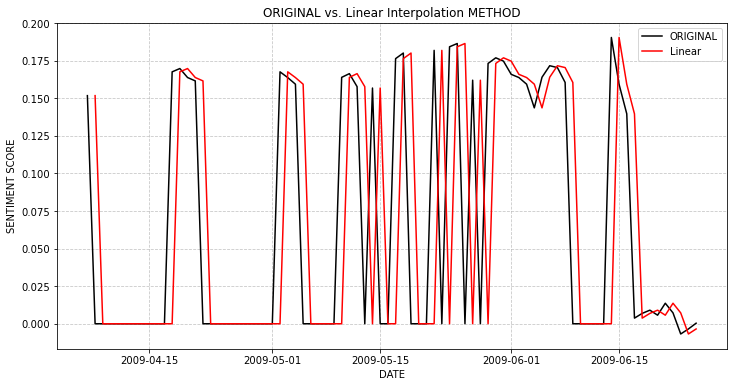

In [79]:
# PLOT CONFIGURATION
plt.figure(figsize=(12, 6))
plt.plot(Dates, Scores, label='ORIGINAL', color='black')

# PLOT THE LINEAR INTERPOLATION METHOD
plt.plot(Dates, [row["LINEAR"] for row in InterList], label='Linear', color='r')

# ADD TITLE AND LABEL
plt.xlabel('DATE')
plt.ylabel('SENTIMENT SCORE')
plt.title('ORIGINAL vs. Linear Interpolation METHOD')

# ADD GRID
plt.grid(True, linestyle='--', alpha=0.7)

# ADD LEGEND
plt.legend()

# SHOW THE PLOT
plt.show()

## 2. KNN Mean Interpolation Plot:

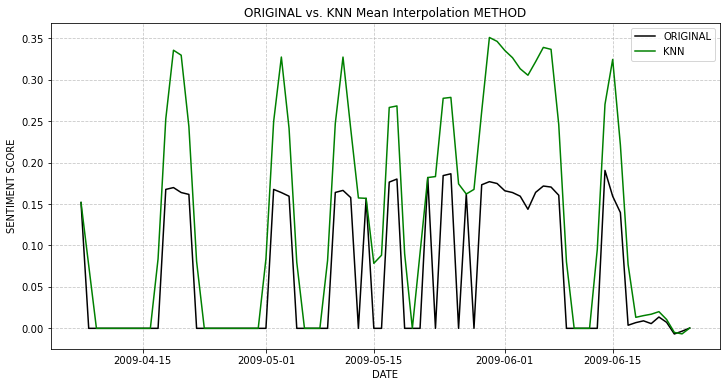

In [80]:
# PLOT CONFIGURATION
plt.figure(figsize=(12, 6))
plt.plot(Dates, Scores, label='ORIGINAL', color='black')

# PLOT THE KNN MEAN INTERPOLATION METHOD
plt.plot(Dates, [row["KNN"] for row in InterList], label='KNN', color='g')

# ADD TITLE AND LABEL
plt.xlabel('DATE')
plt.ylabel('SENTIMENT SCORE')
plt.title('ORIGINAL vs. KNN Mean Interpolation METHOD')

# ADD GRID
plt.grid(True, linestyle='--', alpha=0.7)

# ADD LEGEND
plt.legend()

# SHOW THE PLOT
plt.show()

## 3. Seasonal Mean Interpolation Plot:

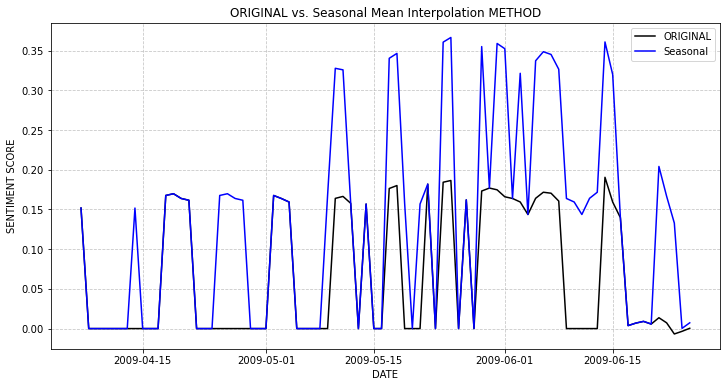

In [81]:
# PLOT CONFIGURATION
plt.figure(figsize=(12, 6))
plt.plot(Dates, Scores, label='ORIGINAL', color='black')

# PLOT THE SEASONAL MEAN INTERPOLATION METHOD
plt.plot(Dates, [row["SEASONAL"] for row in InterList], label='Seasonal', color='b')

# ADD TITLE AND LABEL
plt.xlabel('DATE')
plt.ylabel('SENTIMENT SCORE')
plt.title('ORIGINAL vs. Seasonal Mean Interpolation METHOD')

# ADD GRID
plt.grid(True, linestyle='--', alpha=0.7)

# ADD LEGEND
plt.legend()

# SHOW THE PLOT
plt.show()

## PLOT INTERACTIVE ENTIRE METHODS

In [84]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Dates = [row.YearMonthDateTYPE for row in InterList]
Scores = [row.SenSCOREAvg for row in InterList]
Methods = ["LINEAR", "KNN", "SEASONAL"]
colors = ['red', 'green', 'blue']

# Create subplots with shared x-axis
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=[f'ORIGINAL vs. {Method.title()} METHOD' for Method in Methods])

# Loop through each method
for i, Method in enumerate(Methods):
    # Add trace for ORIGINAL
    fig.add_trace(go.Scatter(x=Dates, y=Scores, mode='lines', name='ORIGINAL', line=dict(color='black')), row=i+1, col=1)
    # Add trace for the INTERPOLATION METHOD
    fig.add_trace(go.Scatter(x=Dates, y=[row[Method] for row in InterList], mode='lines', name=Method.title(), line=dict(color=colors[i])), row=i+1, col=1)

    # Update layout for each subplot
    fig.update_xaxes(title_text='Date', row=i+1, col=1)
    fig.update_yaxes(title_text='Sentiment Score', row=i+1, col=1)
    fig.update_layout(showlegend=True, legend=dict(x=0, y=-1, traceorder='normal', orientation='h'))

# Update overall layout
fig.update_layout(height=1200, width=800, title_text="Sentiment Score Interpolation Methods", showlegend=True)

# Show the interactive plot
fig.show()

In [19]:
%%time

# Use the last non-null value in the 'SenSCOREAvg' column and create a new column 'UP'
InterDF = DF.withColumn("UP", F.last("SenSCOREAvg", True).over(WindowSpecification))

# Use the first non-null value in the 'SenSCOREAvg' column and create a new column 'DOWN'
InterDF = InterDF.withColumn("DOWN", F.first("SenSCOREAvg", True).over(WindowSpecification))

# Create a new column 'VALUE' based on conditions:
# If 'SenSCOREAvg' is 0, set 'VALUE' as the average of 'UP' and 'DOWN'
# Otherwise, set 'VALUE' as the original 'SenSCOREAvg'
InterDF = InterDF.withColumn("VALUE", F.when(F.col("SenSCOREAvg") == 0, (F.col("UP") + F.col("DOWN")) / 2).otherwise(F.col("SenSCOREAvg")))

# Show the first 3 rows of the DataFrame
InterDF.show(3)

2023-11-17 07:37:12,690 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2023-11-17 07:37:12,691 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2023-11-17 07:37:12,692 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|YearMonthDateTYPE|        SenSCOREAvg|             LINEAR|                KNN|           SEASONAL|                 UP|               DOWN|              VALUE|
+-----------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|       2009-04-07|0.15181246190314915|               null|0.15181246190314915|0.15181246190314915|0.15181246190314915|0.15181246190314915|0.15181246190314915|
|       2009-04-08|                0.0|0.15181246190314915|0.07590623095157457|                0.0|                0.0|0.15181246190314915|0.07590623095157457|
|       2009-04-09|                0.0|                0.0|                0.0|                0.0|                0.0|0.15181246190314915|0.07590623095157457|
|       2009-04-10|                0.0| 

In [20]:
# Drop the specified columns from the DataFrame ('InterDF')
InterDF = InterDF.drop("SenSCOREAvg", "LINEAR", "KNN", "SEASONAL", "UP", "DOWN")

# Print the schema of the modified DataFrame
InterDF.printSchema()

root
 |-- YearMonthDateTYPE: date (nullable = true)
 |-- VALUE: double (nullable = true)



#### INTERACTIVE DASHBOARD

In [22]:
import dash
from dash import html, dcc
import plotly.express as px

# Start your Dash application
app = dash.Dash(__name__)

# Create the layout
app.layout = html.Div([
    # Add a dropdown menu
    dcc.Dropdown(
        id='chart-type-dropdown',
        options=[
            {'label': 'LINE GRAPH', 'value': 'line'},
            {'label': 'BAR GRAPH', 'value': 'bar'},
            {'label': 'SCATTER GRAPH', 'value': 'scatter'}
        ],
        value='line',  # Initial chart type to be displayed
        clearable=False,
        style={'width': '50%'}
    ),
    # Section displaying the chart
    dcc.Graph(
        id='chart',
        # Create a figure based on the initial chart type to be displayed
        figure=px.line(InterDF, x='YearMonthDateTYPE', y='VALUE', title='SENTIMENT SCORE')
    )
])

# Respond to changes in the dropdown menu with the callback function
@app.callback(
    dash.dependencies.Output('chart', 'figure'),
    [dash.dependencies.Input('chart-type-dropdown', 'value')]
)
def update_chart(selected_chart_type):
    # Create an appropriate figure based on the selected chart type
    if selected_chart_type == 'bar':
        return px.bar(InterDF, x='YearMonthDateTYPE', y='VALUE', title='SENTIMENT SCORE - BAR CHART')
    elif selected_chart_type == 'scatter':
        return px.scatter(InterDF, x='YearMonthDateTYPE', y='VALUE', title='SENTIMENT SCORE - SCATTER PLOT')
    else:
        return px.line(InterDF, x='YearMonthDateTYPE', y='VALUE', title='SENTIMENT SCORE')

# Run the application
if __name__ == '__main__':
    app.run_server(debug=True, port=8080)


df_for_sentiment_1 === DF
sentiment_score === SenSCORE
date === YearMonthDateTYPE
date_range === YearMonthDateTYPErange
date_range_df === YearMonthDateTYPErange_df
avg_sentiment_score === SenSCOREAvg
window_spec === WindowSpecification
interpolated_data ==== DataFrame
interpolated_value === VALUE
interpolated_df === InterDF
values === VALUES

# ========================
# TIME SERIES FORECASTING
# ========================

In [23]:
%%time

# Convert the InterDF to NumPy array as VALUES
VALUES = InterDF.select("VALUE").rdd.flatMap(lambda x: x).collect()

2023-11-17 07:44:02,085 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


#### ADF ( Augmented Dickey Fuller ) TEST

In [85]:
from statsmodels.tsa.stattools import adfuller

def adf_test_and_print(series, autolag='AIC'):
    # Perform the ADF test
    result_adf = adfuller(series, autolag=autolag)

    # Print the ADF Statistic and p-value
    print(f'ADF Statistic: {result_adf[0]}')
    print(f'p-value: {result_adf[1]}')

    # Print the Critical Values
    print('Critical Values:')
    for key, value in result_adf[4].items():
        print(f' {key}: {value}')

adf_test_and_print(VALUES)

ADF Statistic: -4.224170590892076
p-value: 0.000599501322790417
Critical Values:
 1%: -3.5159766913976376
 5%: -2.898885703483903
 10%: -2.5866935058484217


#### KPSS ( Kwiatkowski-Phillips-Schmidt-Shin ) TEST

In [88]:
from statsmodels.tsa.stattools import kpss

def kpss_test_and_print(series, regression='c'):
    # Perform the KPSS test
    result_kpss = kpss(series, regression=regression)

    # Print the KPSS Statistic and p-value
    print(f'KPSS Statistic: {result_kpss[0]}')
    print(f'p-value: {result_kpss[1]}')

    # Print the Critical Values
    print('Critical Values:')
    for key, value in result_kpss[3].items():
        print(f' {key}: {value}')

kpss_test_and_print(VALUES)

KPSS Statistic: 0.23063307272434677
p-value: 0.1
Critical Values:
 10%: 0.347
 5%: 0.463
 2.5%: 0.574
 1%: 0.739


/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [29]:
# Convert the PySpark DataFrame 'InterDF' to a Pandas DataFrame 'InterDFpandas'
InterDFpandas = InterDF.toPandas()

CPU times: user 20.3 ms, sys: 637 µs, total: 21 ms
Wall time: 249 ms


In [30]:
# Check and display the data types of each column in the Pandas DataFrame 'InterDFpandas'
InterDFpandas.dtypes

YearMonthDateTYPE     object
VALUE                float64
dtype: object

In [31]:
import pandas as pd

# Convert the 'YearMonthDateTYPE' column to datetime objects
InterDFpandas['YearMonthDateTYPE'] = pd.to_datetime(InterDFpandas['YearMonthDateTYPE'], format='%Y/%m/%d')

# Set the 'YearMonthDateTYPE' column as the index
InterDFpandas.set_index('YearMonthDateTYPE', inplace=True)

# Resample with a daily frequency
InterDFpandas = InterDFpandas.resample('D').asfreq()

# Sort the DataFrame by the index
InterDFpandas.sort_index(inplace=True)

# Display the head of the DataFrame
InterDFpandas.head()

,VALUE
YearMonthDateTYPE,
2009-04-07,0.151812
2009-04-08,0.075906
2009-04-09,0.075906
2009-04-10,0.075906
2009-04-11,0.075906


In [32]:
# Split data into train-test
steps = 10

# Split the data into training and test sets
TrainData = InterDFpandas[:-steps]
TestData = InterDFpandas[-steps:]

# Print information about the split
print(f"TRAIN DATES : {TrainData.index.min()} --- {TrainData.index.max()} (n={len(TrainData)})")
print(f"TEST DATES  : {TestData.index.min()} --- {TestData.index.max()} (n={len(TestData)})")

TRAIN DATES : 2009-04-07 00:00:00 --- 2009-06-15 00:00:00 (n=70)
TEST DATES  : 2009-06-16 00:00:00 --- 2009-06-25 00:00:00 (n=10)


### COMPARISON OF TRAINING AND TESTING DATA

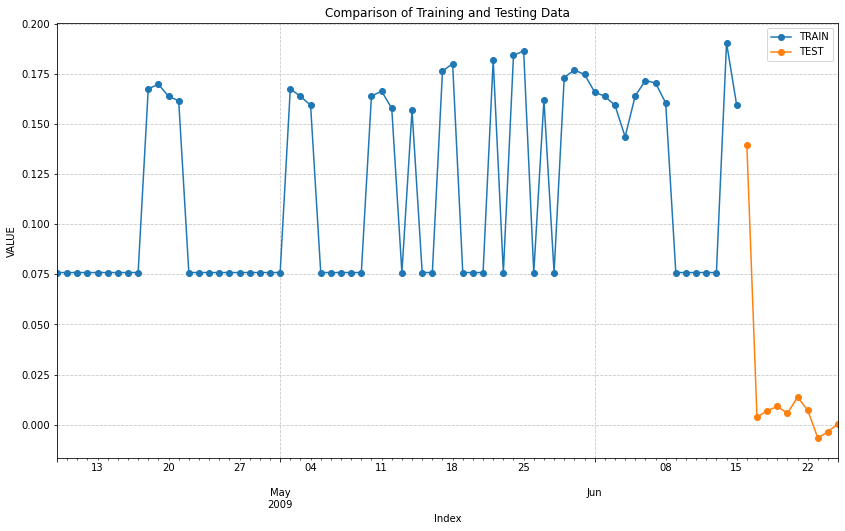

In [94]:
# Plotting the 'VALUE' column of the training and testing datasets
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the 'VALUE' column of the training dataset with markers
TrainData['VALUE'].plot(ax=ax, label='TRAIN', marker='o', linestyle='-')

# Plot the 'VALUE' column of the testing dataset with markers
TestData['VALUE'].plot(ax=ax, label='TEST', marker='o', linestyle='-')

# Add a legend to the plot
ax.legend()

# Set plot labels and title
ax.set_xlabel('Index')
ax.set_ylabel('VALUE')
ax.set_title('Comparison of Training and Testing Data')

# Add a grid
ax.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [95]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

# Define your lag variables
TrainData['outlier1'] = TrainData['VALUE'].shift(1)
TrainData['outlier2'] = TrainData['VALUE'].shift(2)

# Drop missing values
TrainData = TrainData.dropna()

# Create feature matrix X and target variable y
X = TrainData[['outlier1', 'outlier2']]
y = TrainData['VALUE']

# Split the data into training and testing sets (you can adjust test_size as needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Print the coefficients and intercept
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate and print the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Coefficients: [0.34121026 0.10733893]
Intercept: 0.06639316926238756
Mean Squared Error: 0.0015217358966112446


In [35]:
import statsmodels.api as sm

# Define your lag variables
TrainData['outlier1'] = TrainData['VALUE'].shift(1)
TrainData['outlier2'] = TrainData['VALUE'].shift(2)

# Drop missing values
TrainData = TrainData.dropna()

# Create and train AR model
X = TrainData[['outlier1', 'outlier2']]
X = sm.add_constant(X)
y = TrainData['VALUE']

model = sm.OLS(y, X).fit()

# Print model summary
model.summary()

/tmp/ipykernel_3681/3245013581.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3681/3245013581.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  VALUE   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     6.618
Date:                Fri, 17 Nov 2023   Prob (F-statistic):            0.00242
Time:                        07:51:42   Log-Likelihood:                 118.77
No. Observations:                  68   AIC:                            -231.5
Df Residuals:                      65   BIC:                            -224.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0647      0.017      3.885      0.000       0.031       0.098
outlier1       0.3806      0.122      3.111      0.003       0.136       0.625
outlier2       0.0699      0.124      0.563      0.576      -0.178       0.318
==============================================================================
Omnibus:                        5.640   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                3.354
Skew:                           0.348   Prob(JB):                        0.187
Kurtosis:                       2.164   Cond. No.                         28.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
# Initialize lag values
outlier1 = TrainData['outlier1'].iloc[-1]  
outlier2 = TrainData['outlier2'].iloc[-1]  

# Predict 'steps' time periods into the future
ForecastValues = []

for _ in range(steps):
    # Calculate the prediction
    y_pred = model.predict([1, outlier1, outlier2])
    ForecastValues.append(y_pred[0])  # Access the first element directly

    # Update lag values for the next prediction
    outlier2 = outlier1
    outlier1 = y_pred[0]  # Access the first element directly

# Create a DataFrame for the predictions with date index
PredictionDates = TestData.index[-steps:]
predictions = pd.DataFrame({'PREDICTED': ForecastValues}, index=PredictionDates)

# Print the first 20 rows of the DataFrames
# predictions.head(20)
# TestData.head(20)

,PREDICTED
YearMonthDateTYPE,
2009-06-16,0.142494
2009-06-17,0.132222
2009-06-18,0.124955
2009-06-19,0.121472
2009-06-20,0.119638
2009-06-21,0.118697
2009-06-22,0.118211
2009-06-23,0.117960
2009-06-24,0.117830


TEST ERROR (MSE): 0.012348746465417264


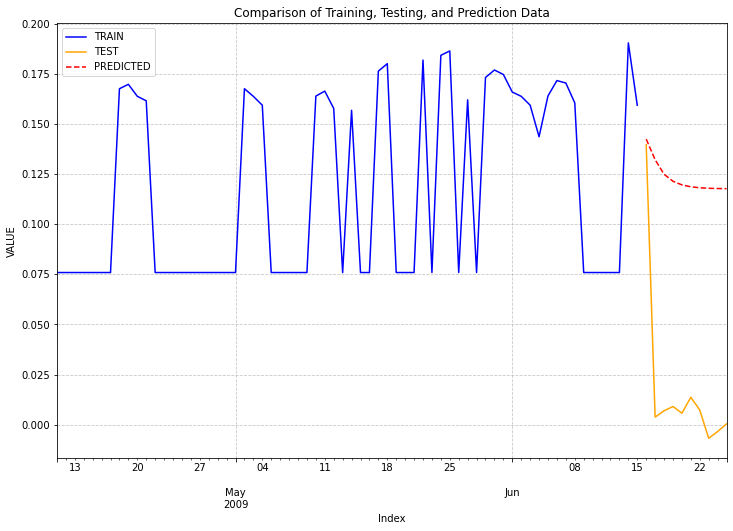

In [99]:
# Plotting the 'VALUE' column of the training and testing datasets along with predictions
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the 'VALUE' column of the training dataset
TrainData['VALUE'].plot(ax=ax, label='TRAIN', color='blue')

# Plot the 'VALUE' column of the testing dataset
TestData['VALUE'].plot(ax=ax, label='TEST', color='orange')

# Plot the predicted values
predictions.plot(ax=ax, label='PREDICTION', linestyle='--', color='red')

# Add grid
ax.grid(True, linestyle='--', alpha=0.7)

# Add legend to the plot
ax.legend()

# Set plot labels and title
ax.set_xlabel('Index')
ax.set_ylabel('VALUE')
ax.set_title('Comparison of Training, Testing, and Prediction Data')

# Calculate the test error (MSE)
error_mse = mean_squared_error(y_true=TestData['VALUE'], y_pred=predictions['PREDICTED'])

# Print the test error
print(f"TEST ERROR (MSE): {error_mse}")

# Show the plot
plt.show()

In [139]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Create and train a RandomForestRegressor with the specified hyperparameters
regressor = RandomForestRegressor(max_depth=3, n_estimators=250, random_state=42)

# Fit the regressor to the training data
regressor.fit(X, y)

RandomForestRegressor(max_depth=2, n_estimators=300, random_state=42)

In [140]:
# Print the length of ForecastValues and ForecastIndex
print("Length of ForecastValues:", len(ForecastValues))
print("Length of ForecastIndex:", len(ForecastIndex))

Length of ForecastValues: 10
Length of ForecastIndex: 10


In [141]:
# Predictions on the test set
ForecastValues = regressor.predict(X_test)

# Create an index for the forecasted values
ForecastIndex = TestData.index[:len(ForecastValues)]

# Take only the first len(ForecastIndex) data points
ForecastValues = ForecastValues[:len(ForecastIndex)]

# Append missing data to the end (e.g., zeros)
while len(ForecastValues) < len(ForecastIndex):
    ForecastValues.append(0)  # or you can append another value

# Convert prediction values and index to a DataFrame
ForecastData = pd.DataFrame({'PREDICTED': ForecastValues}, index=ForecastIndex)

# Print the last 20 rows of the DataFrames
ForecastData.tail()

,PREDICTED
YearMonthDateTYPE,
2009-06-21,0.097015
2009-06-22,0.097015
2009-06-23,0.102063
2009-06-24,0.133948
2009-06-25,0.163176


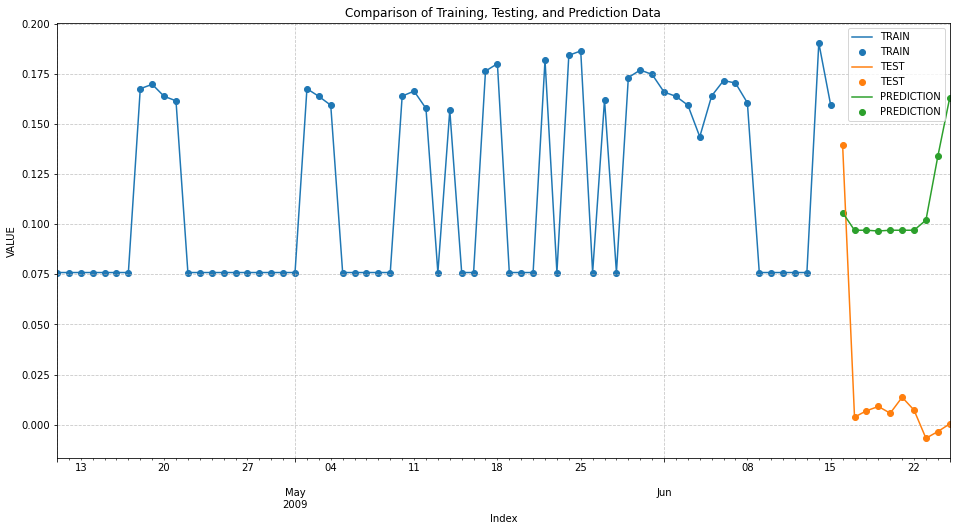

In [143]:
# Plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the 'VALUE' column of the training dataset as a line
TrainData['VALUE'].plot(ax=ax, label='TRAIN')

# Scatter plot the 'VALUE' column of the training dataset as points
ax.scatter(TrainData.index, TrainData['VALUE'], label='TRAIN', marker='o')

# Plot the 'VALUE' column of the testing dataset as a line
TestData['VALUE'].plot(ax=ax, label='TEST')

# Scatter plot the 'VALUE' column of the testing dataset as points
ax.scatter(TestData.index, TestData['VALUE'], label='TEST', marker='o')

# Plot the 'PREDICTED' column of the forecast dataset as a line
ForecastData['PREDICTED'].plot(ax=ax, label='PREDICTION')

# Scatter plot the 'PREDICTED' column of the forecast dataset as points
ax.scatter(ForecastData.index, ForecastData['PREDICTED'], label='PREDICTION', marker='o')

# Add a legend to the plot
ax.legend()

# Set plot labels and title
ax.set_xlabel('Index')
ax.set_ylabel('VALUE')
ax.set_title('Comparison of Training, Testing, and Prediction Data')

# Add grid
ax.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

## AutoRegressive Integrated Moving Average (ARMA)

In [144]:
import itertools

# Define the range of p and q values
p_values = range(3)
q_values = range(3)

# Perform a grid search
best_mse = float('inf')
best_order = None

for p, q in itertools.product(p_values, q_values):
    order = (p, 0, q)  # d=0 for ARMA
    arma_model = ARIMA(TrainData['VALUE'], order=order)
    arma_result = arma_model.fit()

    # Make predictions on the test set
    forecast_values_arma = arma_result.predict(start=len(TrainData), end=len(TrainData) + len(TestData) - 1, typ='levels')

    # Calculate the test error (MSE)
    error_mse_arma = mean_squared_error(y_true=TestData['VALUE'], y_pred=forecast_values_arma)

    # Update best order if the current model is better
    if error_mse_arma < best_mse:
        best_mse = error_mse_arma
        best_order = order

print(f"Best ARMA order: {best_order}")

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Best ARMA order: (0, 0, 1)


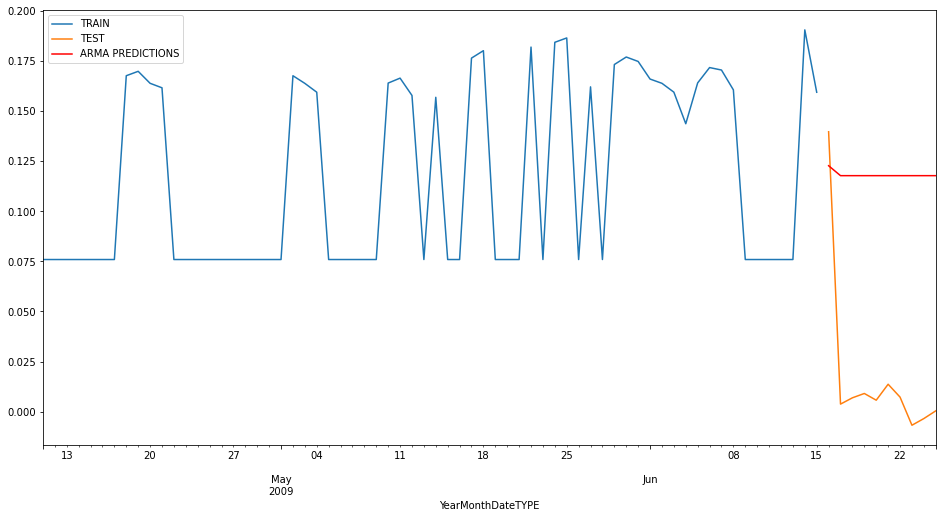

ARMA Test error (MSE): 0.01170183000683153


In [145]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Fit an ARMA model (without seasonality)
order_arma = (0, 0, 1)  # Non-seasonal order

ARMA_model = ARIMA(TrainData['VALUE'], order=order_arma)
ARMA_result = ARMA_model.fit()

# Make predictions on the test set
ForecastValuesARMA = ARMA_result.predict(start=len(TrainData), end=len(TrainData) + len(TestData) - 1, typ='levels')

# Create an index for the forecasted values
ForecastIndexARMA = TestData.index[:len(ForecastValuesARMA)]

# Plot
fig, ax = plt.subplots(figsize=(16, 8))
TrainData['VALUE'].plot(ax=ax, label='TRAIN')
TestData['VALUE'].plot(ax=ax, label='TEST')
ForecastValuesARMA.plot(ax=ax, label='ARMA PREDICTIONS', color='red')
ax.legend()
plt.show()

# Calculate the test error (MSE)
error_mse_arma = mean_squared_error(
    y_true=TestData['VALUE'],
    y_pred=ForecastValuesARMA
)

# Print the test error for ARMA
print(f"ARMA Test error (MSE): {error_mse_arma}")


## AutoRegressive Integrated Moving Average (ARIMA)

In [146]:
import itertools

# Define the range of p, d, and q values
p_values = range(0, 3)
d_values = range(0, 1)  # Assuming your data is non-seasonal
q_values = range(0, 3)

# Generate all possible combinations of p, d, and q
orders = list(itertools.product(p_values, d_values, q_values))

# Initialize variables to store best parameters and lowest AIC
best_aic = float("inf")
best_order = None

# Iterate over all combinations
for order in orders:
    try:
        # Fit the ARIMA model
        model = ARIMA(TrainData['VALUE'], order=order)
        result = model.fit()

        # Check AIC
        aic = result.aic

        # Update best parameters if current AIC is lower
        if aic < best_aic:
            best_aic = aic
            best_order = order
    except:
        continue

# Print the best parameters
print(f"Best ARIMA Order: {best_order} with AIC: {best_aic}")

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Best ARIMA Order: (2, 0, 2) with AIC: -223.5796774407103


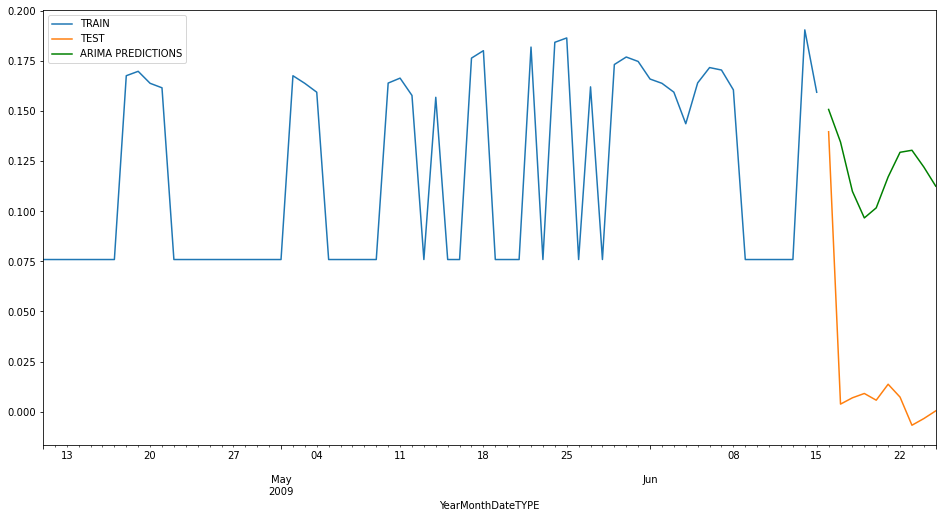

ARIMA Test error (MSE): 0.011755393597907475


In [147]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model
order_arima = (2, 0, 2)  # Non-seasonal order

ARIMA = ARIMA(TrainData['VALUE'], order=order_arima)
ARIMAresult = ARIMA.fit()

# Make predictions on the test set
ForecastValuesARIMA = ARIMAresult.predict(start=len(TrainData), end=len(TrainData) + len(TestData) - 1, typ='levels')

# Create an index for the forecasted values
ForecastIndexARIMA = TestData.index[:len(ForecastValuesARIMA)]

# Plot
fig, ax = plt.subplots(figsize=(16, 8))
TrainData['VALUE'].plot(ax=ax, label='TRAIN')
TestData['VALUE'].plot(ax=ax, label='TEST')
ForecastValuesARIMA.plot(ax=ax, label='ARIMA PREDICTIONS', color='green')
ax.legend()
plt.show()

# Calculate the test error (MSE)
error_mse_arima = mean_squared_error(
    y_true=TestData['VALUE'],
    y_pred=ForecastValuesARIMA
)

# Print the test error for ARIMA
print(f"ARIMA Test error (MSE): {error_mse_arima}")


## Seasonal AutoRegressive Integrated Moving Average (SARIMA)

In [148]:
import itertools

# Define the range of p, d, q, P, D, Q, and S values
p_values = range(0, 3)
d_values = range(0, 1)  # Assuming your data is non-seasonal
q_values = range(0, 3)
P_values = range(0, 2)
D_values = range(0, 1)  # Assuming your data is non-seasonal
Q_values = range(0, 2)
s_values = [7]  # Assuming weekly seasonality, adjust as needed

# Generate all possible combinations of p, d, q, P, D, Q, and S
orders = list(itertools.product(p_values, d_values, q_values))
seasonal_orders = list(itertools.product(P_values, D_values, Q_values, s_values))

# Initialize variables to store best parameters and lowest AIC
best_aic = float("inf")
best_order = None
best_seasonal_order = None

# Iterate over all combinations
for order in orders:
    for seasonal_order in seasonal_orders:
        try:
            # Fit the SARIMA model
            model = SARIMAX(TrainData['VALUE'], order=order, seasonal_order=seasonal_order)
            result = model.fit(disp=False)

            # Check AIC
            aic = result.aic

            # Update best parameters if current AIC is lower
            if aic < best_aic:
                best_aic = aic
                best_order = order
                best_seasonal_order = seasonal_order
        except:
            continue

# Print the best parameters
print(f"Best SARIMA Order: {best_order} and Seasonal Order: {best_seasonal_order} with AIC: {best_aic}")

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa

Best SARIMA Order: (1, 0, 1) and Seasonal Order: (1, 0, 1, 7) with AIC: -218.0654124167277


/home/hduser/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.24256D-01    |proj g|=  4.24521D+01

At iterate    5    f= -1.09365D+00    |proj g|=  7.66905D+00

At iterate   10    f= -1.66531D+00    |proj g|=  9.22513D-01

At iterate   15    f= -1.66772D+00    |proj g|=  7.87690D-01

At iterate   20    f= -1.69482D+00    |proj g|=  1.51101D+00

At iterate   25    f= -1.70206D+00    |proj g|=  1.04075D+00

At iterate   30    f= -1.71881D+00    |proj g|=  2.21779D-01

At iterate   35    f= -1.72211D+00    |proj g|=  1.75343D-01

At iterate   40    f= -1.72624D+00    |proj g|=  2.18858D-01

At iterate   45    f= -1.72777D+00    |proj g|=  1.90436D-02

At iterate   50    f= -1.72777D+00    |proj g|=  1.84540D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



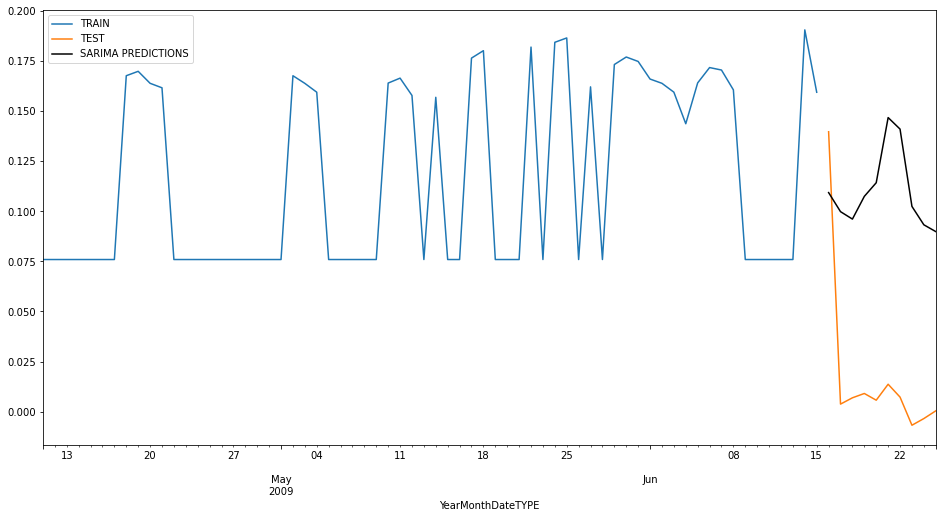

SARIMA Test error (MSE): 0.010447119447456027


In [149]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a SARIMA model
order = (1, 0, 1)  # Non-seasonal order
seasonal_order = (1, 0, 1, 7)  # Seasonal order (p, d, q, S)

SARIMA = SARIMAX(TrainData['VALUE'], order=order, seasonal_order=seasonal_order)
SARIMAresult = SARIMA.fit()

# Make predictions on the test set
ForecastValuesSARIMA = SARIMAresult.predict(start=len(TrainData), end=len(TrainData) + len(TestData) - 1, typ='levels')

# Create an index for the forecasted values
ForecastIndexSARIMA = TestData.index[:len(ForecastValuesSARIMA)]

# Plot
fig, ax = plt.subplots(figsize=(16, 8))
TrainData['VALUE'].plot(ax=ax, label='TRAIN')
TestData['VALUE'].plot(ax=ax, label='TEST')
ForecastValuesSARIMA.plot(ax=ax, label='SARIMA PREDICTIONS', color='black')
ax.legend()
plt.show()

# Calculate the test error (MSE)
error_mse_sarima = mean_squared_error(
    y_true=TestData['VALUE'],
    y_pred=ForecastValuesSARIMA
)

# Print the test error for SARIMA
print(f"SARIMA Test error (MSE): {error_mse_sarima}")

## Simple Exponential Smoothing (SES) Model

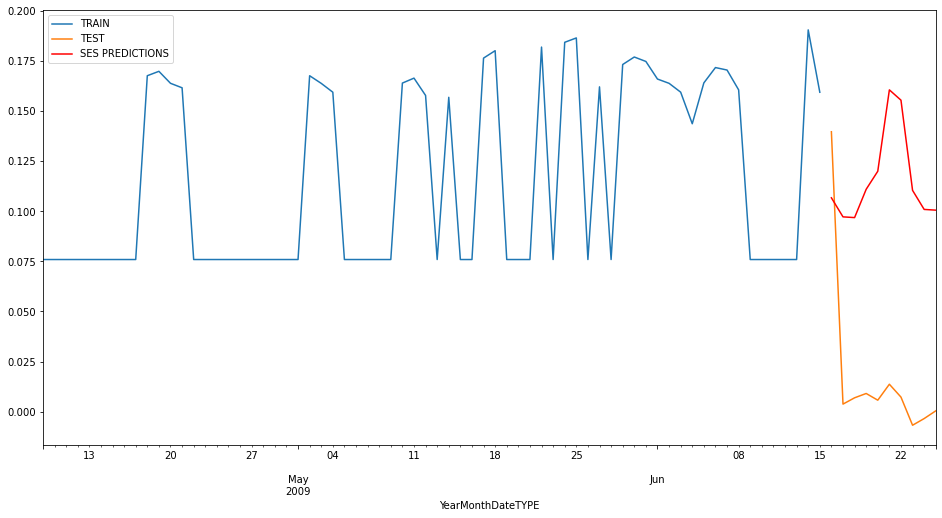

SES Test error (MSE): 0.011959276289301634


In [74]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit a Simple Exponential Smoothing (SES) model
ses_model = ExponentialSmoothing(TrainData['VALUE'], trend='add', seasonal='add', seasonal_periods=7)
ses_result = ses_model.fit()

# Make predictions on the test set
ForecastValuesSES = ses_result.predict(start=len(TrainData), end=len(TrainData) + len(TestData) - 1)

# Create an index for the forecasted values
ForecastIndexSES = TestData.index[:len(ForecastValuesSES)]

# Plot
fig, ax = plt.subplots(figsize=(16, 8))
TrainData['VALUE'].plot(ax=ax, label='TRAIN')
TestData['VALUE'].plot(ax=ax, label='TEST')
ForecastValuesSES.plot(ax=ax, label='SES PREDICTIONS', color='red')
ax.legend()
plt.show()

# Calculate the test error (MSE) for SES
error_mse_ses = mean_squared_error(
    y_true=TestData['VALUE'],
    y_pred=ForecastValuesSES
)

# Print the test error for SES
print(f"SES Test error (MSE): {error_mse_ses}")

# ================================
# MYSQL CONNECTION AND YCSB TEST
# ================================

In [ ]:
!mysql --version

In [ ]:
%%time
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession.builder.appName("MySQL").getOrCreate()

# Read CSV file with Spark DataFrame
mysql_df = spark.read.csv("/ProjectTweets.csv", header=False, inferSchema=True)

In [ ]:
# INITILAZE THE MYSQL IN TERMINAL
# !mysql -u root -p

In [ ]:
%%time
# Configure MySQL Database Connection
MySQL_Configuration = {
    "url": "jdbc:mysql://localhost:3306/sample",
    "driver": "com.mysql.cj.jdbc.Driver",
    "dbtable": "yourtable",
    "user": "root",
    "password": "password"
}

In [ ]:
%%time
# Load DataFrame into MySQL database
mysql_df.write.format("jdbc").options(**MySQL_Configuration).mode("overwrite").save()

In [ ]:
%%time
# Read DataFrame via MySQL
mysql_df = spark.read.jdbc(url = "jdbc:mysql://localhost:3306/sample",
                           table = "yourtable",
                           properties = MySQL_Configuration)

In [ ]:
%%time
# Show DataFrame via MySQL
mysql_df.show()

In [ ]:
%%time
# YCSB TEST FOR MYSQL
!/home/hduser/ycsb-0.17.0/bin/ycsb.sh run jdbc -P /home/hduser/ycsb-0.17.0/workloads/workloada -p db.url=jdbc:mysql://localhost:3306/sample -p db.user=root -p db.passwd=password -p db.driver=com.mysql.cj.jdbc.Driver

# ===================================
# MONGODB CONNECTION AND YCSB TEST
# ===================================

In [ ]:
!mongo --version

In [ ]:
%%time
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession.builder.appName("MongoDB").getOrCreate()

# Read CSV file with Spark DataFrame
mongodb_df = spark.read.csv("/ProjectTweets.csv", header=False, inferSchema=True)

In [ ]:
# INITILAZE THE MONGODB IN TERMINAL
# mongod

In [ ]:
%%time
# Configure MongoDB Database Connection
mongodb_df.write.format("mongodb") \
                .option("uri","mongodb://127.0.0.1:27017/") \
                .option("database","TweetDatabaseMongoDB") \
                .option("collection","TweetCollectionMongoDB") \
                .mode("append").save()

In [ ]:
# Show DataFrame via MongoDB
mongodb_df.show()

In [ ]:
%%time
# YCSB TEST FOR MONGODB
!/home/hduser/ycsb-0.17.0/bin/ycsb.sh run mongodb -P /home/hduser/ycsb-0.17.0/workloads/workloada -p mongodb.url=mongodb://localhost:27017 -p mongodb.database=TweetDatabaseMongoDB 